# XGBoost

## PACE Single Day

(405, 93, 163, 172)
Data shape (after masking): (215, 172)
Labels shape: (215,)
Dates shape: (215,)
[[-2.3036799e-03 -2.0480568e-03 -1.7953771e-03 ...  5.3680232e-03
   4.6585016e-03  4.3228683e-03]
 [ 1.5699262e-03  1.9994942e-03  2.2910424e-03 ...  3.9135306e-03
   3.4755785e-03  3.2161900e-03]
 [ 6.5488038e-03  6.6216746e-03  6.7013116e-03 ...  4.6397825e-03
   4.0858067e-03  3.8033377e-03]
 ...
 [ 3.6760634e-03  3.7517629e-03  3.8014855e-03 ...  3.6310258e-03
   3.1256245e-03  2.8579044e-03]
 [ 2.7580594e-03  3.0080893e-03  3.1714772e-03 ...  2.2357279e-03
   1.9406852e-03  1.7913989e-03]
 [-6.9099246e-04 -2.8259496e-04 -6.2855652e-05 ...  1.7099938e-03
   1.4439132e-03  1.3625810e-03]]
[0]	validation_0-logloss:0.67755
[1]	validation_0-logloss:0.65667
[2]	validation_0-logloss:0.64241
[3]	validation_0-logloss:0.62772
[4]	validation_0-logloss:0.61402
[5]	validation_0-logloss:0.60371
[6]	validation_0-logloss:0.59128
[7]	validation_0-logloss:0.58294
[8]	validation_0-logloss:0.57189
[9]

/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68777/4080486221.py:40: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)



XGBoost Confusion Matrix (Threshold = 0.6):
[[103   4]
 [ 13  95]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.8879    0.9626    0.9238       107
           1     0.9596    0.8796    0.9179       108

    accuracy                         0.9209       215
   macro avg     0.9238    0.9211    0.9208       215
weighted avg     0.9239    0.9209    0.9208       215



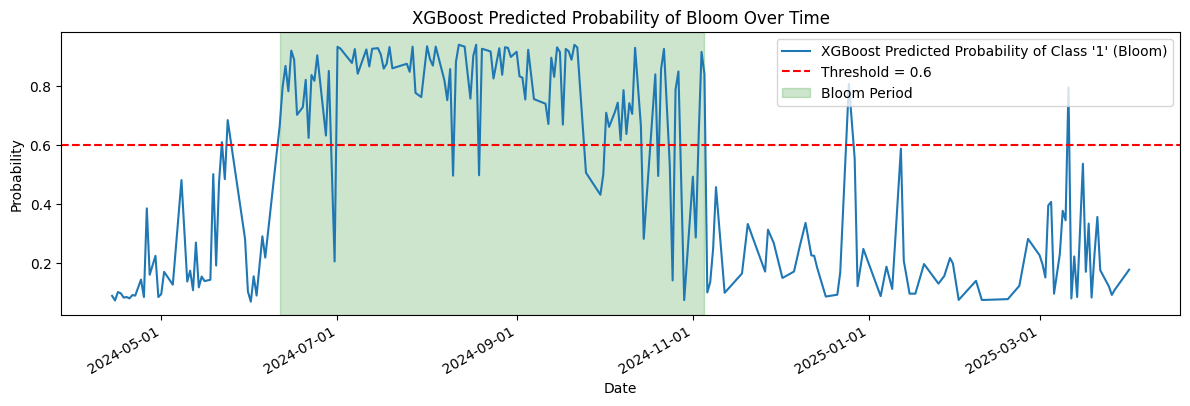

In [3]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load data
ndarray_all = np.load("../../Images/composite_data_PACE.npy")  # shape (n, h, w, c)

print(ndarray_all.shape)

with open("../../Images/composite_metadata_PACE.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.6

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print(data_imputed)

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_imputed, labels, test_size=0.2, random_state=42)


# Set up the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,       # Number of trees
    max_depth=4,            # Max tree depth (smaller than RF to prevent overfitting)
    learning_rate=0.05,      # Learning rate (eta)
    early_stopping_rounds=20,
    subsample=0.8,          # Row subsampling
    colsample_bytree=0.8,   # Feature subsampling
    random_state=42,        # Reproducibility
    eval_metric='logloss'   # Avoids warning for binary classification
)

# Cross-validation (time-ordered split)
cv = StratifiedKFold(n_splits=5, shuffle=False)
#xgb_scores = cross_val_score(xgb_model, data_imputed, labels, cv=cv, scoring='roc_auc')

#print("\nXGBoost StratifiedKFold ROC-AUC scores:", xgb_scores)
#print("Mean ROC-AUC:", xgb_scores.mean())

eval_set = [(X_val, y_val)]


# Train final XGBoost model on full data
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict probabilities
y_prob_xgb = xgb_model.predict_proba(data_imputed)[:, 1]

# Thresholded predictions
y_pred_xgb = (y_prob_xgb >= decision_threshold).astype(int)

# Confusion matrix
cm_xgb = confusion_matrix(labels, y_pred_xgb)
print(f"\nXGBoost Confusion Matrix (Threshold = {decision_threshold}):")
print(cm_xgb)

# Classification report
print("\nXGBoost Classification Report:")
print(classification_report(labels, y_pred_xgb, digits=4))

# Plot probabilities over time
plt.figure(figsize=(12, 4))
plt.plot(dates, y_prob_xgb, label="XGBoost Predicted Probability of Class '1' (Bloom)")

plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("XGBoost Predicted Probability of Bloom Over Time")
plt.legend()
plt.tight_layout()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


## Sentinel-3 Single Day

(405, 93, 163, 21)
Data shape (after masking): (287, 21)
Labels shape: (287,)
Dates shape: (287,)
[[0.00682453 0.00799797 0.0108903  ... 0.01175316 0.0116519  0.00881627]
 [0.00785309 0.00920529 0.01192999 ... 0.00896752 0.00881405 0.00614312]
 [0.00674751 0.00789688 0.01055617 ... 0.00676279 0.00659706 0.00427003]
 ...
 [0.02808443 0.02501602 0.01899861 ... 0.00319627 0.00307649 0.0013542 ]
 [0.0038505  0.00514364 0.00757852 ... 0.00528385 0.00519436 0.00331246]
 [0.00494158 0.00599333 0.00825985 ... 0.00659021 0.00652039 0.0044251 ]]
[0]	validation_0-logloss:0.69001
[1]	validation_0-logloss:0.67210
[2]	validation_0-logloss:0.65259
[3]	validation_0-logloss:0.63616
[4]	validation_0-logloss:0.62304
[5]	validation_0-logloss:0.60910
[6]	validation_0-logloss:0.59895
[7]	validation_0-logloss:0.58831
[8]	validation_0-logloss:0.57880
[9]	validation_0-logloss:0.56752
[10]	validation_0-logloss:0.56144
[11]	validation_0-logloss:0.55943
[12]	validation_0-logloss:0.55478
[13]	validation_0-logloss:

/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68777/1566606399.py:40: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)
/Users/jessecox/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


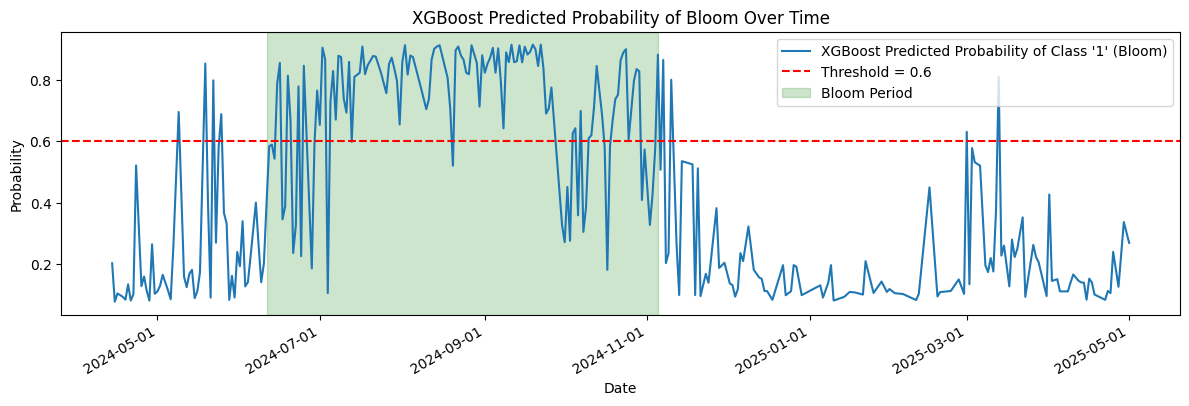

In [4]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load data
ndarray_all = np.load("../../Images/composite_data_S3.npy")  # shape (n, h, w, c)

print(ndarray_all.shape)

with open("../../Images/composite_metadata_S3.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.6

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print("data_imputed:\n",data_imputed)

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_imputed, labels, test_size=0.2, random_state=42)


# Set up the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,       # Number of trees
    max_depth=4,            # Max tree depth (smaller than RF to prevent overfitting)
    learning_rate=0.05,      # Learning rate (eta)
    early_stopping_rounds=20,
    subsample=0.8,          # Row subsampling
    colsample_bytree=0.8,   # Feature subsampling
    random_state=42,        # Reproducibility
    eval_metric='logloss'   # Avoids warning for binary classification
)

# Cross-validation (time-ordered split)
cv = StratifiedKFold(n_splits=5, shuffle=False)
#xgb_scores = cross_val_score(xgb_model, data_imputed, labels, cv=cv, scoring='roc_auc')

#print("\nXGBoost StratifiedKFold ROC-AUC scores:", xgb_scores)
#print("Mean ROC-AUC:", xgb_scores.mean())

eval_set = [(X_val, y_val)]


# Train final XGBoost model on full data
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict probabilities
y_prob_xgb = xgb_model.predict_proba(data_imputed)[:, 1]

# Thresholded predictions
y_pred_xgb = (y_prob_xgb >= decision_threshold).astype(int)

# Confusion matrix
cm_xgb = confusion_matrix(labels, y_pred_xgb)
print(f"\nXGBoost Confusion Matrix (Threshold = {decision_threshold}):")
print(cm_xgb)

# Classification report
print("\nXGBoost Classification Report:")
print(classification_report(labels, y_pred_xgb, digits=4))

# Plot probabilities over time
plt.figure(figsize=(12, 4))
plt.plot(dates, y_prob_xgb, label="XGBoost Predicted Probability of Class '1' (Bloom)")

plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("XGBoost Predicted Probability of Bloom Over Time")
plt.legend()
plt.tight_layout()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


## Pace 7 Day

(405, 93, 163, 172)
Data shape (after masking): (359, 172)
Labels shape: (359,)
Dates shape: (359,)
[[ 9.7254670e-04  1.1806728e-03  1.4089056e-03 ...  5.8082798e-03
   5.0863437e-03  4.6318686e-03]
 [-5.0250208e-04 -2.7325057e-04 -2.9379929e-05 ...  6.1416076e-03
   5.3346264e-03  4.8503582e-03]
 [ 9.9584773e-05  3.9202027e-04  6.5091264e-04 ...  5.5235587e-03
   4.8213629e-03  4.4012303e-03]
 ...
 [-6.9099234e-04 -2.8259456e-04 -6.2855856e-05 ...  1.7099935e-03
   1.4439129e-03  1.3625806e-03]
 [-6.9099234e-04 -2.8259491e-04 -6.2855768e-05 ...  1.7099935e-03
   1.4439125e-03  1.3625806e-03]
 [-6.9099246e-04 -2.8259508e-04 -6.2855652e-05 ...  1.7099938e-03
   1.4439132e-03  1.3625810e-03]]
[0]	validation_0-logloss:0.63467
[1]	validation_0-logloss:0.60472
[2]	validation_0-logloss:0.57537
[3]	validation_0-logloss:0.55162
[4]	validation_0-logloss:0.53046
[5]	validation_0-logloss:0.50866
[6]	validation_0-logloss:0.48976
[7]	validation_0-logloss:0.47338
[8]	validation_0-logloss:0.45616
[9]

/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68777/760799232.py:40: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)


[73]	validation_0-logloss:0.15802
[74]	validation_0-logloss:0.15762
[75]	validation_0-logloss:0.15627
[76]	validation_0-logloss:0.15386
[77]	validation_0-logloss:0.15272
[78]	validation_0-logloss:0.15236
[79]	validation_0-logloss:0.15119
[80]	validation_0-logloss:0.15156
[81]	validation_0-logloss:0.15147
[82]	validation_0-logloss:0.15143
[83]	validation_0-logloss:0.15053
[84]	validation_0-logloss:0.14870
[85]	validation_0-logloss:0.14769
[86]	validation_0-logloss:0.14708
[87]	validation_0-logloss:0.14674
[88]	validation_0-logloss:0.14552
[89]	validation_0-logloss:0.14509
[90]	validation_0-logloss:0.14506
[91]	validation_0-logloss:0.14406
[92]	validation_0-logloss:0.14325
[93]	validation_0-logloss:0.14267
[94]	validation_0-logloss:0.14161
[95]	validation_0-logloss:0.14089
[96]	validation_0-logloss:0.14039
[97]	validation_0-logloss:0.13859
[98]	validation_0-logloss:0.13732
[99]	validation_0-logloss:0.13707
[100]	validation_0-logloss:0.13621
[101]	validation_0-logloss:0.13490
[102]	valida

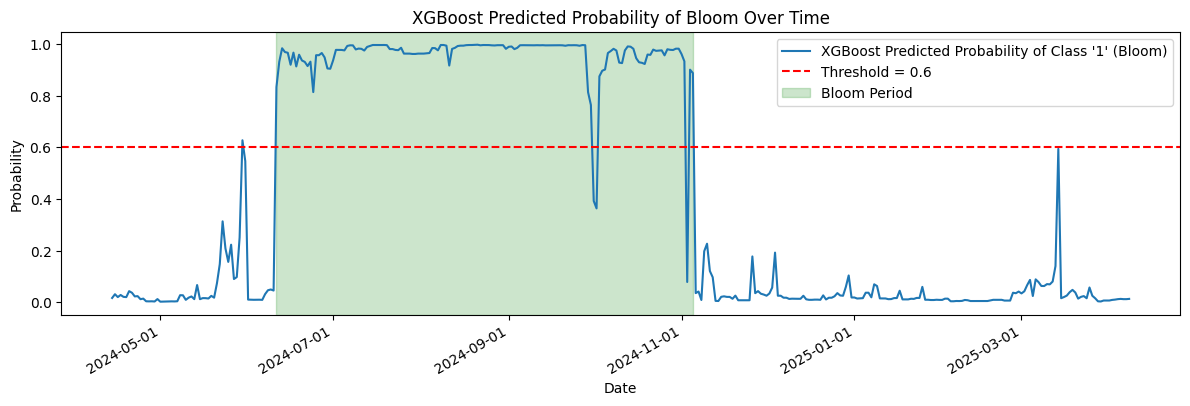

In [5]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load data
ndarray_all = np.load("../../Images/composite_data_PACE_full.npy")  # shape (n, h, w, c)

print(ndarray_all.shape)

with open("../../Images/composite_metadata_PACE.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.6

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print(data_imputed)

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_imputed, labels, test_size=0.2, random_state=42)


# Set up the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,       # Number of trees
    max_depth=4,            # Max tree depth (smaller than RF to prevent overfitting)
    learning_rate=0.05,      # Learning rate (eta)
    early_stopping_rounds=20,
    subsample=0.8,          # Row subsampling
    colsample_bytree=0.8,   # Feature subsampling
    random_state=42,        # Reproducibility
    eval_metric='logloss'   # Avoids warning for binary classification
)

# Cross-validation (time-ordered split)
cv = StratifiedKFold(n_splits=5, shuffle=False)
#xgb_scores = cross_val_score(xgb_model, data_imputed, labels, cv=cv, scoring='roc_auc')

#print("\nXGBoost StratifiedKFold ROC-AUC scores:", xgb_scores)
#print("Mean ROC-AUC:", xgb_scores.mean())

eval_set = [(X_val, y_val)]


# Train final XGBoost model on full data
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict probabilities
y_prob_xgb = xgb_model.predict_proba(data_imputed)[:, 1]

# Thresholded predictions
y_pred_xgb = (y_prob_xgb >= decision_threshold).astype(int)

# Confusion matrix
cm_xgb = confusion_matrix(labels, y_pred_xgb)
print(f"\nXGBoost Confusion Matrix (Threshold = {decision_threshold}):")
print(cm_xgb)

# Classification report
print("\nXGBoost Classification Report:")
print(classification_report(labels, y_pred_xgb, digits=4))

# Plot probabilities over time
plt.figure(figsize=(12, 4))
plt.plot(dates, y_prob_xgb, label="XGBoost Predicted Probability of Class '1' (Bloom)")

plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("XGBoost Predicted Probability of Bloom Over Time")
plt.legend()
plt.tight_layout()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()
